# BTC Forecasting

Time series forecasting is a technique used to predict future values based on previously observed values over time. It involves analyzing historical data points collected at consistent intervals to identify trends, seasonal patterns, and cyclical behavior. This methodology is particularly significant in financial markets, where understanding price movements can inform investment decisions.

Forecasting Bitcoin (BTC) prices is valuable due to the cryptocurrency's volatility and potential for high returns. Accurate predictions can aid swing traders in making informed decisions about entry and exit points, thereby optimizing their trading strategies.

In [1]:
# Setup

import os
import IPython
import IPython.display
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [15]:
# Load dataset
from google.colab import drive

drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Machine_Learning/Dataset/BTC/bitcoin_historical_data.csv'

data = pd.read_csv(file_path)
data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Date,Price,Open,High,Low,Vol.,Change %
0,09/19/2024,"62,938.6","61,754.8","63,849.6","61,596.5",120.17K,1.91%
1,09/18/2024,"61,757.6","60,308.5","61,757.6","59,210.7",105.57K,2.40%
2,09/17/2024,"60,309.1","58,213.1","61,309.0","57,630.2",106.30K,3.60%
3,09/16/2024,"58,213.1","59,126.2","59,204.3","57,527.8",87.60K,-1.56%
4,09/15/2024,"59,138.5","59,995.6","60,377.6","58,717.9",47.01K,-1.43%


Before diving into further analysis, it's important to get a statistical overview of the dataset to better understand its structure. In the next step, I will use data.describe() to calculate descriptive statistics for all numerical columns in the dataset. This will give me insights into key metrics such as the mean, standard deviation, minimum and maximum values, as well as the distribution of the data across different percentiles.

In [16]:
data.describe().transpose()

,count,unique,top,freq
Date,2454,2454,09/19/2024,1
Price,2454,2445,"16,831.8",2
Open,2454,2438,"10,104.9",2
High,2454,2439,"8,145.5",2
Low,2454,2448,"6,337.8",2
Vol.,2454,2342,1.05M,6
Change %,2454,1071,0.05%,10


## Identified Problems:
- Non-Numerical Data in 'Vol.' and 'Change %':

    The Vol. column contains values like 1.05M, which is not in a pure numerical format.
    This is an issue because machine learning models require numeric values for training, and having units like 'M' (for million) can prevent the model from understanding the true magnitude of these values.

- String Percentages in 'Change %':

    The Change % column contains percentage symbols, which must be removed and the values converted to floats for proper numerical analysis.

- Top and Frequent Values:

    The describe() function shows that some values, like the top 'Price', 'Open', and 'Vol.' occur more than once (frequency greater than 1). This indicates possible duplicate rows that may need to be removed.

- Unique Values Issue:

    There are many unique entries in the columns that should not have unique values if they were purely numeric (e.g., Price or Open), indicating that some non-numeric elements might still be present or incorrectly formatted.

## Preprocessing

To prepare the data for analysis and model training, several transformations are applied to clean and convert the columns into numerical formats:

- Convert 'Date' to Datetime Format:

    The 'Date' column is initially a string, but for time-series analysis, it needs to be in a proper datetime format. The pd.to_datetime() function converts the 'Date' column into a Pandas datetime object, making it easier to work with for forecasting and time-based operations.

- Remove Commas and Convert Price-Related Columns to Float:

    Columns like 'Price', 'Open', 'High', and 'Low' contain commas in the numbers (e.g., '16,831.8'), which prevent them from being directly used in calculations. The commas are removed using .str.replace(), and the values are converted to floats for numerical processing.

- Handle 'Vol.' (Volume) by Removing 'K', 'M', and 'B' Notations:

    The 'Vol.' column contains notations like 'K' (thousands), 'M' (millions), and 'B' (billions) which are common in financial data. These symbols are replaced by their respective scientific notation values (e3, e6, and e9) to represent the numbers accurately. The values are then converted into floats for consistency in calculations.

- Convert 'Change %' to a Numeric Format:

    The 'Change %' column has percentage values, but the '%' symbol needs to be removed for the numbers to be treated as floats. After removing the symbol, the values are converted to floats so they can be processed properly.

In [17]:
data['Date'] = pd.to_datetime(data['Date'])

# Remove commas from numeric columns and convert them to floats
data['Price'] = data['Price'].str.replace(',', '').astype(float)
data['Open'] = data['Open'].str.replace(',', '').astype(float)
data['High'] = data['High'].str.replace(',', '').astype(float)
data['Low'] = data['Low'].str.replace(',', '').astype(float)

# Remove 'K', 'M' and 'B' from 'Vol.' and convert to float
data['Vol.'] = data['Vol.'].str.replace('K', 'e3') \
                            .str.replace('M', 'e6') \
                            .str.replace('B', 'e9') \
                            .str.replace(',', '')
data['Vol.'] = data['Vol.'].astype(float)

# Remove '%' from 'Change %' and convert to float
data['Change %'] = data['Change %'].str.replace('%', '').astype(float)

# Display the first few rows
data.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
Date,2454,2021-05-11 12:00:00,2018-01-01 00:00:00,2019-09-06 06:00:00,2021-05-11 12:00:00,2023-01-14 18:00:00,2024-09-19 00:00:00,NaN
Price,2454.0,25834.793806,3228.7,8808.15,20528.7,40325.525,73066.3,19403.125775
Open,2454.0,25814.927547,3228.6,8810.025,20489.5,40149.3,73066.7,19390.167324
High,2454.0,26415.880073,3282.3,9006.025,20989.15,41509.75,73740.9,19831.007201
Low,2454.0,25168.532967,3177.0,8557.1,20064.35,39276.475,71338.4,18913.026954
Vol.,2454.0,25129312.746536,260.0,73692.5,164875.0,515967.5,4470000000.0,220365768.242729
Change %,2454.0,0.127885,-39.18,-1.44,0.05,1.6675,19.41,3.607618


In time series analysis, the order of data points matters, as we typically want to analyze trends over time. Therefore, I will sort the dataset in ascending order based on the 'Date' column using sort_values(by='Date'). This ensures that the oldest data appears first, and the most recent data appears last, which is essential for forecasting models.

After sorting, the 'Date' column is no longer needed in the main dataset for model training, but it will be useful for referencing later. Using data.pop('Date'), I extract the 'Date' column and store it in a separate variable dates. This allows me to work with the numerical features while keeping the dates accessible for any future visualizations or comparisons.


In [18]:
data = data.sort_values(by='Date')

dates = data.pop('Date')
print(dates.head())

2453   2018-01-01
2452   2018-01-02
2451   2018-01-03
2450   2018-01-04
2449   2018-01-05
Name: Date, dtype: datetime64[ns]


## Step: Visualizing Key Features Over Time

- Select Columns to Plot:

    To understand how each feature behaves over time, I'll select the important columns for visualization: Price, Open, High, Low, Vol., and Change %. These columns represent crucial indicators of Bitcoin's performance and will provide insights into trends, fluctuations, and relationships between these metrics.

- Set the Date Index:

    Time series data is often indexed by time (dates in this case) to facilitate temporal analysis. I assign the dates we previously extracted as the index for our selected features (plot_features.index = dates), which enables plotting the data against the correct time axis.

- Plot the Features:

    Using the plot function with subplots=True, I plot each feature in a separate subplot. This allows us to visualize how each of the selected columns changes over time, helping to identify patterns, spikes, and dips in the dataset. Each subplot gives a clear picture of the individual behavior of these features.


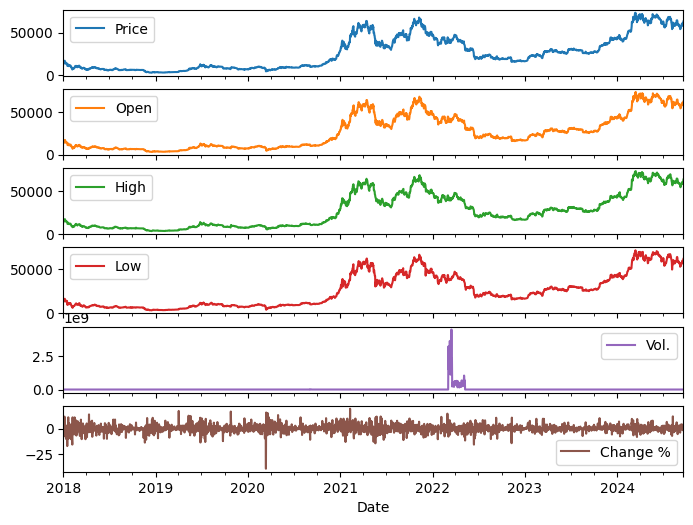

In [19]:
plot_cols = ['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']
plot_features = data[plot_cols]
plot_features.index = dates
_ = plot_features.plot(subplots=True)


In this step, I focus on scaling important features to prepare the data for machine learning models. I select the features Price, Open, High, Low, Vol., and Change %, which need to be normalized to ensure they contribute equally to the model's predictions. To achieve this, I initialize a Min-Max Scaler, which transforms the data to a fixed range of [0, 1]. By applying scaler.fit_transform() to the selected features, I ensure that they are scaled appropriately, improving the model's performance and stability during training.

In [20]:
from sklearn.preprocessing import MinMaxScaler

features_to_scale = ['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']

scaler = MinMaxScaler()
data[features_to_scale] = scaler.fit_transform(data[features_to_scale])
print(data.head())

         Price      Open      High       Low      Vol.  Change %
2453  0.146285  0.152093  0.150999  0.142320  0.000017  0.618706
2452  0.165031  0.146285  0.170651  0.143148  0.000031  0.834955
2451  0.170795  0.165032  0.172480  0.167290  0.000024  0.715310
2450  0.171131  0.170794  0.172107  0.162375  0.000025  0.671275
2449  0.196543  0.171132  0.196493  0.170997  0.000032  0.868237


Define a method for creating sequences from the dataset to prepare it for time series forecasting. The sequence_length to 7, meaning I will use 7 days of historical data to predict the next day's price, as indicated by the forecast_horizon of 1. The function create_sequences() iterates through the data, extracting overlapping sequences of the specified length along with corresponding target values. Each sequence contains features for 7 consecutive days, while the target is the price of the day immediately following that sequence. After generating the sequences, I convert them into NumPy arrays for model input.

In [21]:
sequence_length = 7
forecast_horizon = 1

# Create sequences of data with shape (number of sequences, sequence length, number of features)
def create_sequences(data, sequence_length, forecast_horizon):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length - forecast_horizon + 1):
        sequences.append(data[i:i + sequence_length])
        targets.append(data[i + sequence_length + forecast_horizon - 1][0])
    return np.array(sequences), np.array(targets)

data_values = data[['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']].values
X, y = create_sequences(data_values, sequence_length, forecast_horizon)

print("Input shape (X):", X.shape)
print("Target shape (y):", y.shape)

Input shape (X): (2447, 7, 6)
Target shape (y): (2447,)


In [22]:
# Train Test Splitting
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# tf.data.Dataset

Convert the training and test data into TensorFlow datasets to facilitate efficient model training. Using tf.data.Dataset.from_tensor_slices(), I create two datasets: train_dataset and test_dataset, which consist of the input sequences (X_train) and their corresponding targets (y_train for training and y_test for testing). This method allows TensorFlow to handle the data more effectively during the training process. Next, I batch both datasets with a specified BATCH_SIZE of 32. Batching helps to process multiple samples simultaneously, improving training efficiency and allowing the model to learn from the data in manageable portions.

In [23]:
# Convert training and test data to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Batch the datasets
BATCH_SIZE = 32
train_dataset = train_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Recurrent Neural Network

Build and compile an RNN model using TensorFlow's Keras API to predict Bitcoin prices. I'll be using a Sequential model and with two LSTM layers, each with 64 units and a dropout layer set at 20% to prevent overfitting. The first LSTM layer is configured to return sequences, as it feeds into the second LSTM layer. The final layer is a dense layer with a single output, which corresponds to the predicted price. After defining the model architecture, I'll compile it using the Adam optimizer and specify the mean squared error (MSE) as the loss function, along with mean absolute error (MAE) as an additional metric.

Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0072 - mae: 0.0588 - val_loss: 0.0955 - val_mae: 0.2692
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0076 - mae: 0.0662 - val_loss: 0.1242 - val_mae: 0.3117
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0096 - mae: 0.0650 - val_loss: 0.0970 - val_mae: 0.2747
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0075 - mae: 0.0502 - val_loss: 0.0613 - val_mae: 0.2115
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0062 - mae: 0.0439 - val_loss: 0.0311 - val_mae: 0.1407
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0050 - mae: 0.0418 - val_loss: 0.0193 - val_mae: 0.1090
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0032 - mae: 0.0332 - val_loss: 0.0116 - val_mae: 0.0827
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0023 - mae: 0.0276 - val_loss: 0.0105 - val_mae: 0.0816
Epoch 9/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.001

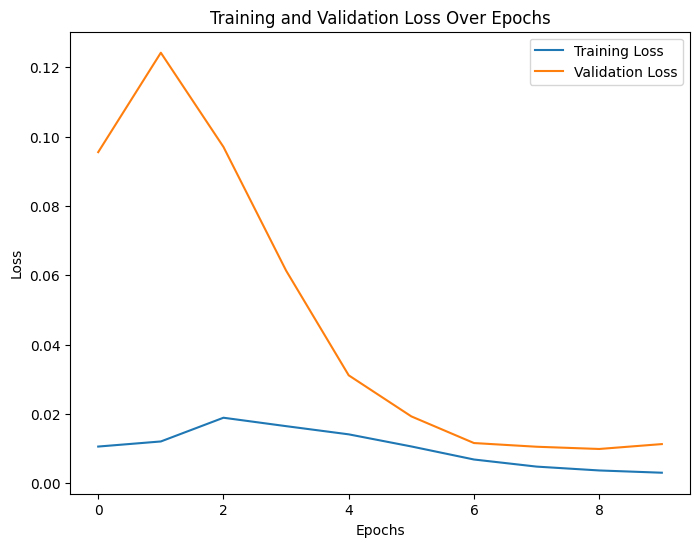

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build and compile RNN model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(sequence_length, X.shape[2])),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# train
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=test_dataset,
                    validation_split=0.2)

train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the losses
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The results of the training show that after 10 epochs, the model achieved a training loss of 0.0015 and a mean absolute error (MAE) of 0.0228. This indicates that the model is effectively minimizing the loss during training, suggesting that it has learned to predict Bitcoin prices fairly well on the training dataset.

In contrast, the validation loss is 0.0113 with a validation MAE of 0.0875. While the validation loss is higher than the training loss, this discrepancy is common and can indicate that the model may not generalize as well to unseen data. The validation MAE suggests that the model's predictions for the test dataset deviate more significantly from the actual prices compared to its performance on the training data.

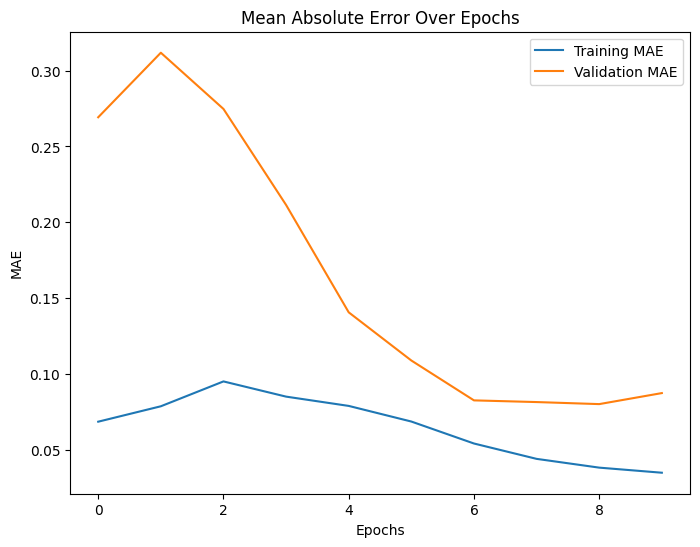

In [41]:
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


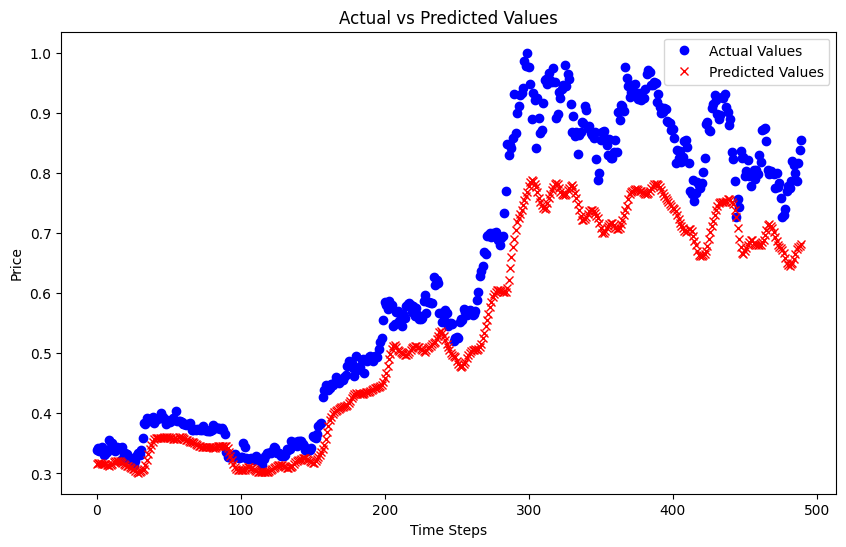

In [42]:
predictions = model.predict(X_test)


plt.figure(figsize=(10, 6))
plt.plot(y_test, 'o', label='Actual Values', color='blue')
plt.plot(predictions, 'x', label='Predicted Values', color='red')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()